In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import os

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Data load

In [2]:
df = pd.read_csv('hourly_entsoe_dayahead_prices_since2022')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert("Europe/Amsterdam")
df["price_eur_mwh"] = df["price_eur_mwh"]/1000
df = df.rename(columns={'price_eur_mwh': 'price_eur_kwh'})

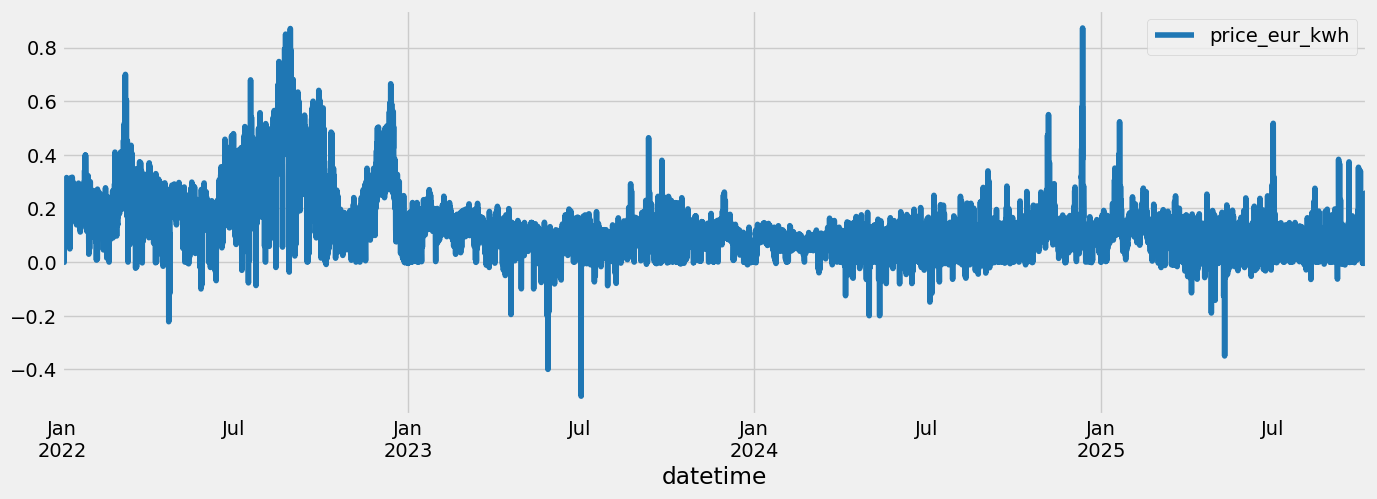

In [3]:
df.plot(figsize=(15,5), color=color_pal[0])
plt.show()

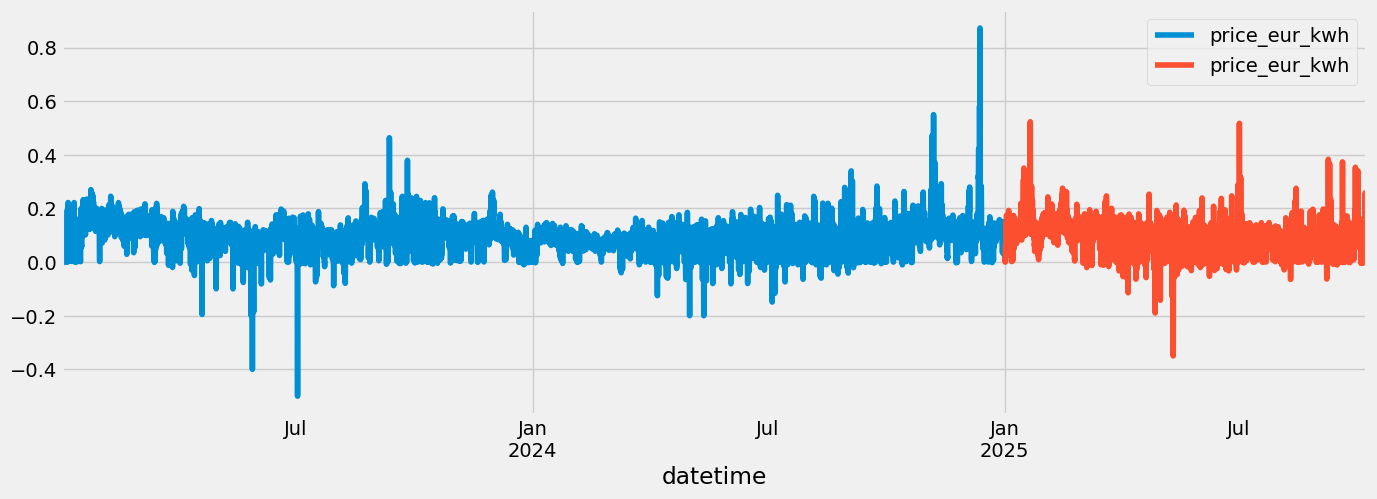

In [4]:
train = df.loc[(df.index < '01-01-2025')& (df.index > '01-01-2023')]
test = df.loc[df.index >= '01-01-2025']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.show()


# Train / Test split

In [5]:
# add cross validation

In [6]:
weather = pd.read_csv('hourly_knmi_weather')
weather = weather.set_index('datetime')
weather.index = pd.to_datetime(weather.index, utc=True)
weather.index = weather.index.tz_convert("Europe/Amsterdam")

In [7]:
df = df.join(weather, how="inner").dropna()

In [8]:
train = df.loc[(df.index < '01-01-2025')& (df.index > '01-01-2023')]
test = df.loc[df.index >= '01-01-2025']


Additional features?:
- gas prices

In [9]:

def solar_performance_metric(rad, ambient, gamma=-0.0035, NOCT=45.0):
    """
    Compute an effective solar performance metric that accounts for irradiance,
    module temperature, and efficiency losses.

    This metric represents an adjusted irradiance value (in W/m²-equivalent)
    that approximates the combined effects of irradiance level, temperature,
    and cell performance characteristics. It is useful for estimating
    photovoltaic (PV) performance under non-standard test conditions.

    Parameters
    ----------
    rad : float or array_like
        Solar irradiance in joules per square centimeter per hour (J/cm²/h).
        Typical range: 0–3600 J/cm²/h (equivalent to 0–1000 W/m²).
    ambient : float or array_like
        Ambient temperature in degrees Celsius (°C).
    gamma : float, optional
        Temperature coefficient of power (per °C). Defaults to -0.0035.
        Negative values indicate power decreases with increasing temperature.
    NOCT : float, optional
        Nominal Operating Cell Temperature in degrees Celsius (°C).
        Defaults to 45.0. Used in estimating cell temperature rise under
        irradiance.

    Returns
    -------
    metric : float or ndarray
        Effective solar performance metric (0–1000 range), representing
        adjusted irradiance in W/m²-equivalent after accounting for
        temperature and irradiance nonlinearity.

    References
    ----------
    - IEC 61853-1: Photovoltaic (PV) module performance testing and energy rating
    - Duffie, J.A., & Beckman, W.A. (2013). *Solar Engineering of Thermal Processes*.

    """
    conv = 10000.0 / 3600.0  # J/cm²/h -> W/m²
    R = rad * conv      # W/m²

    T = ambient + (NOCT - 20.0) / 800.0 * R
    a = 1.0 - 0.2 * np.exp(-R / 200.0)
    irradiance_factor = (R / 1000.0) ** a

    temp_factor = 1.0 + gamma * (T - 25.0)
    temp_factor = np.maximum(temp_factor, 0.0)  # element-wise

    metric = 1000.0 * irradiance_factor * temp_factor
    metric = np.clip(metric, 0.0, 1000.0)       # element-wise clip

    return metric

def wind_performance_metric(wind_speeds, cut_in=3.0, rated=12.0, cut_out=25.0, derate_at_cutout=0.90):
    """
    Compute a wind turbine performance metric scaled from 0 to 1000,
    with a cubic ramp-up to rated speed and a slight derating between
    rated and cut-out.

    Parameters
    ----------
    wind_speeds : array-like
        List or array of wind speeds in m/s.
    cut_in : float, default=3.0
        Cut-in wind speed (below this, no power).
    rated : float, default=12.0
        Rated wind speed (power plateaus here).
    cut_out : float, default=25.0
        Cut-out wind speed (above this, turbine shuts down).
    derate_at_cutout : float, default=0.90
        Fraction of rated power at cut-out (e.g., 0.90 = 90%).

    Returns
    -------
    numpy.ndarray
        Integer array of performance metrics in range [0, 1000].
    """
    ws = np.array(wind_speeds, dtype=float)
    metric = np.zeros_like(ws)

    # Between cut-in and rated → cubic growth
    mask_ramp = (ws >= cut_in) & (ws < rated)
    denom = (rated**3 - cut_in**3) if rated > cut_in else 1.0
    metric[mask_ramp] = (ws[mask_ramp]**3 - cut_in**3) / denom

    # Between rated and cut-out → linear derating
    mask_derate = (ws >= rated) & (ws <= cut_out)
    if cut_out > rated:
        slope = (1.0 - derate_at_cutout) / (cut_out - rated)
        metric[mask_derate] = 1.0 - slope * (ws[mask_derate] - rated)
    else:
        metric[mask_derate] = 1.0

    # Normalize and scale to 0–1000 integer metric
    metric = np.clip(metric, 0.0, 1.0)
    metric_0_1000 = (metric * 1000).round().astype(int)

    return metric_0_1000

def degree_days_cool(temp, cutover=24):
    """
    Calculate cooling degree days (CDD) for a series of temperatures.

    Cooling degree days quantify the demand for cooling (e.g., air conditioning)
    based on how much and how long the daily temperature exceeds a given threshold.

    Parameters
    ----------
    temp : pandas.Series
        Series of daily mean temperatures (°C).
    cutover : float, optional
        Threshold temperature (°C) above which cooling is required.
        Defaults to 24°C.

    Returns
    -------
    pandas.Series
        Cooling degree days for each temperature value. Values are zero if
        the temperature is below or equal to the cutover.
    """
    return temp.apply(lambda T: cutover - T if T > cutover else 0)

def degree_days_heat(temp, cutover=18):
    """
    Calculate heating degree days (HDD) for a series of temperatures.

    Heating degree days quantify the demand for heating (e.g., space heating)
    based on how much and how long the daily temperature falls below a given threshold.

    Parameters
    ----------
    temp : pandas.Series
        Series of daily mean temperatures (°C).
    cutover : float, optional
        Threshold temperature (°C) below which heating is required.
        Defaults to 18°C.

    Returns
    -------
    pandas.Series
        Heating degree days for each temperature value. Values are zero if
        the temperature is above or equal to the cutover.
    """
    return temp.apply(lambda T: cutover - T if T < cutover else 0)

def create_features(df):
    """
    Perform feature engineering on a time-indexed DataFrame for energy modeling.

    This function generates time-based and weather-related features from
    the input DataFrame, which is assumed to have a DatetimeIndex and
    columns for 'temperature', 'irradiance', and 'wind_speed'. It also
    computes derived performance metrics for solar and wind energy, and
    heating/cooling degree days.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with at least the following columns:
        - 'temperature' : float, ambient temperature in °C
        - 'irradiance' : float, solar irradiance in J/cm²/h
        - 'wind_speed' : float, wind speed in m/s
        The DataFrame index must be a pandas.DatetimeIndex.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the following additional columns:
        - 'day_of_week' : int, day of the week (0=Monday, 6=Sunday)
        - 'hour' : int, hour of the day (0–23)
        - 'quarter' : int, quarter of the year (1–4)
        - 'month' : int, month of the year (1–12)
        - 'season' : int, mapped season (0=winter, 1=spring, 2=summer, 3=autumn)
        - 'solar_performance' : float, estimated solar performance metric
        - 'wind_performance' : float, estimated wind performance metric
        - 'dd_heat' : float, heating degree days
        - 'dd_cool' : float, cooling degree days
    """
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['season'] = df.index.month.map({
        12: 0, 1: 0, 2: 0,    # winter
        3: 1, 4: 1, 5: 1,     # spring
        6: 2, 7: 2, 8: 2,     # summer
        9: 3, 10: 3, 11: 3    # autumn
    })
    df['solar_performance'] = solar_performance_metric(df['irradiance'], df['temperature']).astype(float)
    df['wind_performance'] = wind_performance_metric(df['wind_speed']).astype(float)
    df['dd_heat'] = degree_days_heat(df['temperature'])
    df['dd_cool'] = degree_days_cool(df['temperature'])
    return df
    

# Visualize

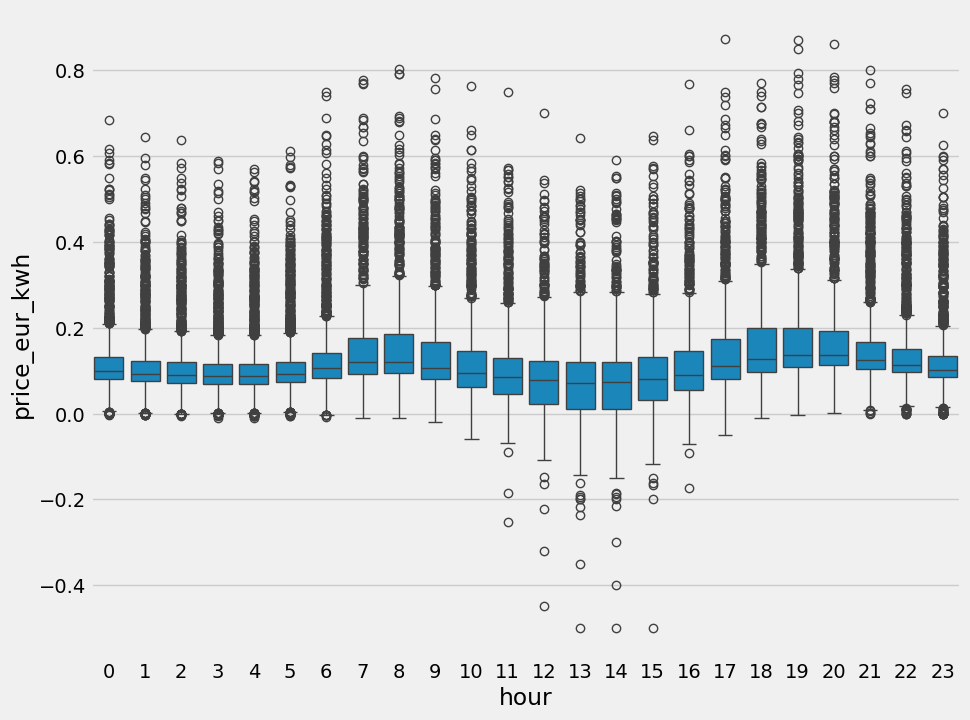

In [10]:
df = create_features(df)

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'hour', y = 'price_eur_kwh')
plt.show()

# Create Model

In [11]:
train = create_features(train)
test = create_features(test)
FEATURES_FORECAST = [ 'temperature', 'precipitation', 'irradiance',
       'wind_speed', 'day_of_week', 'hour', 'quarter', 'month', 'season' ]
FEATURES_METRICS = [ 'temperature', 'precipitation', 'solar_performance',
       'wind_performance', 'day_of_week', 'hour', 'quarter', 'month', 'season' ]
FEATURES_FORECAST_AND_METRICS = [ 'temperature', 'precipitation', 'irradiance', 'solar_performance',
       'wind_speed', 'wind_performance', 'day_of_week', 'hour', 'quarter', 'month', 'season' ]
FEATURES_FORECAST_AND_METRICS_AND_DD = [ 'temperature', 'precipitation', 'irradiance', 'solar_performance',
       'wind_speed', 'wind_performance', 'day_of_week', 'hour', 'quarter', 'month', 'season', 'dd_heat', 'dd_cool' ]
TARGET = 'price_eur_kwh'



In [12]:
def create_model(features, n_estimators=901, early_stopping_rounds=50, learning_rate=0.01, max_depth=5):
    # create train and test set
    X_train = train[features]
    y_train = train[TARGET]

    X_test = test[features]
    y_test = test[TARGET]

    # train model
    reg = xgb.XGBRegressor(n_estimators=n_estimators, early_stopping_rounds=early_stopping_rounds, learning_rate=learning_rate, max_depth=max_depth)
    reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

    # feature importance
    fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

    fi.sort_values('importance').plot(kind='barh')
    plt.show()

    # forcast on set
    test['prediction'] = reg.predict(X_test)
    model_df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = model_df[['price_eur_kwh']].plot(figsize=(15,5))
    model_df['prediction'].plot(ax=ax, style='.')
    plt.show()

    # show a week prediction
    daterange = (model_df.index > '09-27-2025') & (model_df.index < '10-04-2025')
    
    ax = model_df.loc[daterange]['price_eur_kwh'] \
    .plot(figsize=(15,5), title='Week of Data')
    model_df.loc[daterange]['prediction'] \
        .plot(style='.')
    plt.legend(['Truth Data', 'Prediction'])
    plt.show()

    # score
    score = np.sqrt(mean_squared_error(test['price_eur_kwh'], test['prediction']))
    print(f'RMSE Score on {features}\n Test set: {score:0.4}')
    return reg
             

In [13]:
#create_model(FEATURES_FORECAST)

In [14]:
#create_model(FEATURES_METRICS)

In [15]:
#create_model(FEATURES_FORECAST_AND_METRICS)

[0]	validation_0-rmse:0.04994	validation_1-rmse:0.05307
[100]	validation_0-rmse:0.03746	validation_1-rmse:0.03788
[200]	validation_0-rmse:0.03294	validation_1-rmse:0.03303
[300]	validation_0-rmse:0.03084	validation_1-rmse:0.03114
[400]	validation_0-rmse:0.02967	validation_1-rmse:0.03027
[500]	validation_0-rmse:0.02889	validation_1-rmse:0.02987
[600]	validation_0-rmse:0.02836	validation_1-rmse:0.02962
[700]	validation_0-rmse:0.02777	validation_1-rmse:0.02944
[800]	validation_0-rmse:0.02731	validation_1-rmse:0.02933
[900]	validation_0-rmse:0.02702	validation_1-rmse:0.02928


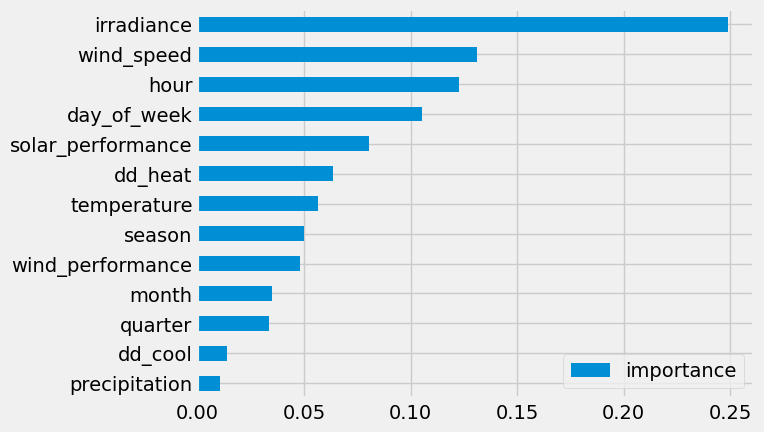

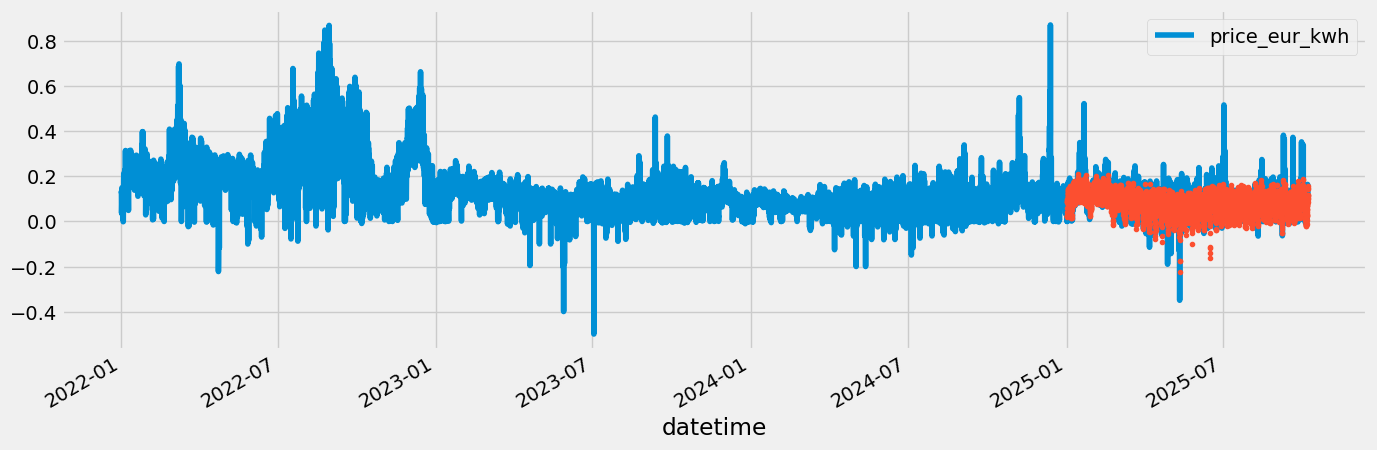

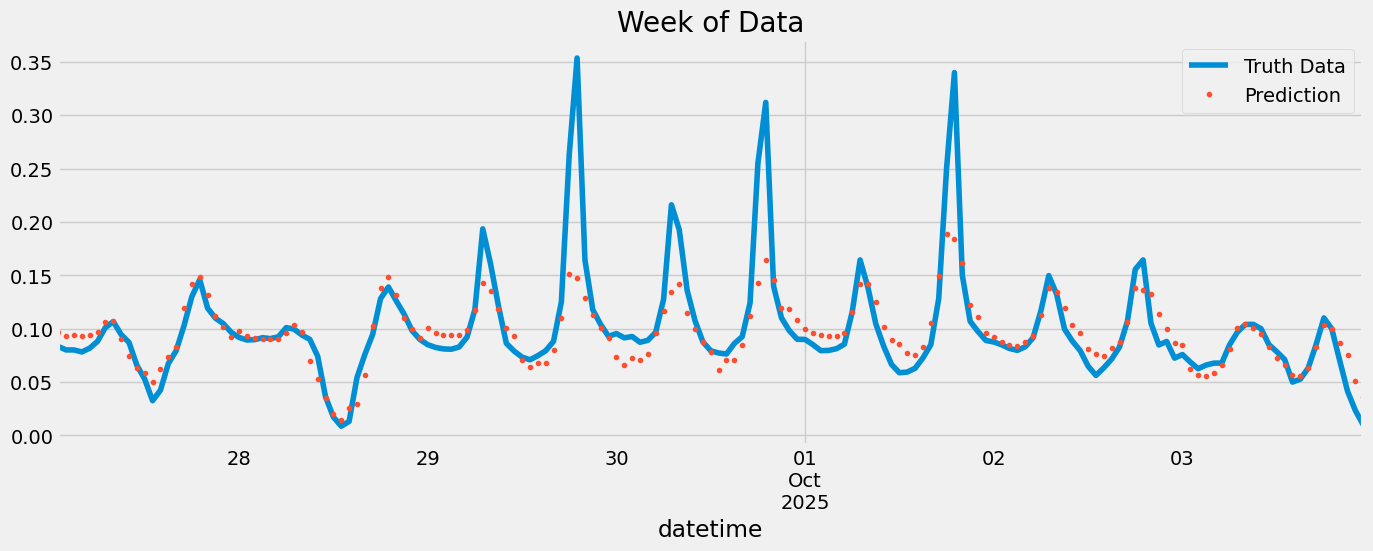

RMSE Score on ['temperature', 'precipitation', 'irradiance', 'solar_performance', 'wind_speed', 'wind_performance', 'day_of_week', 'hour', 'quarter', 'month', 'season', 'dd_heat', 'dd_cool']
 Test set: 0.02928


In [16]:
my_model = create_model(FEATURES_FORECAST_AND_METRICS_AND_DD)

# Hyper parameter training

In [17]:
# create_model(features=FEATURES_FORECAST_AND_METRICS_AND_DD,n_estimators=901,early_stopping_rounds=50,learning_rate=0.01, max_depth=5)

# save final model

In [18]:
my_model.save_model("daysahead_xgb_model.json") 

```python
import pandas as pd
import xgboost as xgb

# ----------------------------
# 1. Load the saved model
# ----------------------------

model = xgb.XGBRegressor()
model.load_model("xgb_model.json")

X_new = forecast()
X_new = create_features(X_new)
X_new = X_new[model.get_booster().feature_names]

predictions = loaded_model.predict(X_new)  # or X_new if no scaling

print("Predictions:", predictions)
```